In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [4]:
from tqdm import tqdm
import numpy as np
from V8Suprabhash import get_stock_data, add_features,  plot_performance

In [11]:
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
########################## Changes made here ##################################
def get_model(num_features, num_actions, num_dense_layers, neurons_per_layer):
    model = Sequential()
    model.add(InputLayer(batch_input_shape=(1, num_features+num_actions)))
    for i in range(num_dense_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(num_actions, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model
###############################################################################

In [6]:
features = [
    {"feature": "Close_as_a_feature", "lookback": 0},
    {"feature": "diff_of_close", "lookback": 1},
]

#Experiment params
ticker = 'sinx'#'NIFc1'
tune = False
train_percent = 0.8
state_lookback = 1
num_dense_layers = 2
num_dense_layers_by_num_features = 2
alpha = 0.5
epsilon = 0.1
gamma = 0.1
episodes = 100
metric = "percent"

############################################################################################################################################

#Get data
df = get_stock_data(ticker)
df = add_features(df, features, state_lookback, 0.8)
train_df = df.iloc[:int(0.8 * len(df)), :]
test_df = df.iloc[int(0.8 * len(df)):, :]


########################## Changes made here ##################################
all_actions = {0: 'percentage_invested_in_equity'}
###############################################################################

model = get_model(len(features)*state_lookback, len(all_actions), num_dense_layers, len(features)*state_lookback*num_dense_layers_by_num_features)
# visualizer(model, format='png', view=True)

array([0.15416284, 0.7400497 , 0.26331502, 0.53373939, 0.01457496,
       0.91874701, 0.90071485, 0.03342143, 0.95694934, 0.13720932])

In [51]:
def train_q_learning(train, state_lookback, model, alpha, epsilon, gamma, episodes, all_actions, metric, features, number_of_random_samples, plot=True):

    train_data = train.copy()
    returns_vs_episodes = []
    best_episode_return = 0
    weights_best_performing = None

    arr = np.empty(shape=(0,len(features)*state_lookback+len(all_actions)))
    arr1 = train_data[[feature['feature'] for feature in features] + [f"{col}_shift{i}" for col in [feature['feature'] for feature in features] for i in range(1, state_lookback)]].values
    for i in range(len(arr1)):
        random_actions = np.random.uniform(0,1,number_of_random_samples)
        for j in range(number_of_random_samples):
            arr = np.vstack((arr,np.r_[arr1[i], random_actions[j]]))

    for ii in tqdm(range(episodes)):

        #Backtester initialisation
        balance = 10000
        net_worth = balance
        in_position = False
        number_of_units_in_position = 0
        position_value = 0.0
        actions_history = []
        equity_curve = []
        rewards = []
        states = []
        prices = []
        current_q_all_states = []
        next_q_all_states = []

        q = model.predict(arr)
        current_qs = []
        next_qs = []
        actions = []
        for i in range(len(arr1)):
            q_list = []
            next_q_list = []
            for j in range(number_of_random_samples):
                q_list.append(q[i*number_of_random_samples+j])
            for j in range(number_of_random_samples):
                next_q_list.append(q[(i+1)*number_of_random_samples+j])
            next_qs.append(max(next_q_list))
            current_qs.append(max(q_list))
            actions.append(arr[q_list.index(max(q_list))][-1])

        current_qs = current_qs.reshape(-1,1)
        next_qs = next_qs.reshape(-1,1)
        actions = actions.reshape(-1,1)

        # for i in range(1,len(train_data)):
        #     current_adj_close = train_data.iloc[i]["Close"]
        #     last_day_adj_close = train_data.iloc[i - 1]["Close"]
        #     prices.append(current_adj_close)
        #     states.append(arr[i])
        #     current_q_all_states.append(current_qs[i][0])
        #
        #     # decide action
        #     if epsilon > 0.1:
        #         epsilon = epsilon / 1.2
        #
        #     if np.random.uniform(0, 1) < epsilon:
        #         action = np.random.uniform(0,1)
        #     else:
        #         action= actions[i][0]
        #
        #     actions_history.append(action)
        #
        #     if not in_position:
        #         if action == 1:  # OPEN LONG
        #             in_position = True
        #             number_of_units_in_position = balance/current_adj_close
        #             balance = balance - (number_of_units_in_position*current_adj_close)
        #             position_value = number_of_units_in_position*current_adj_close
        #             net_worth = balance + position_value
        #             equity_curve.append(net_worth)
        #             rewards.append(0)
        #         else:
        #             net_worth = balance + position_value
        #             equity_curve.append(net_worth)
        #             rewards.append(0)
        #     else:
        #         if action == 1:  # HOLD LONG
        #             position_value = number_of_units_in_position*current_adj_close
        #             net_worth = balance + position_value
        #             equity_curve.append(net_worth)
        #             try:
        #                 if metric == "absolute":
        #                     rewards.append(equity_curve[-1] - equity_curve[-2])
        #                 else:
        #                     rewards.append((equity_curve[-1] - equity_curve[-2]) / equity_curve[-2])
        #             except:
        #                 rewards.append(0)
        #         else:  # CLOSE LONG
        #             balance = balance + (number_of_units_in_position*current_adj_close)
        #             in_position = False
        #             position_value = 0.0
        #             number_of_units_in_position = 0
        #             net_worth = balance + position_value
        #             equity_curve.append(net_worth)
        #             rewards.append(0)
        #
        #     try:
        #         next_q_all_states.append(next_qs[i][0])
        #     except:
        #         break

        arr_fit_X = np.empty(shape=(0,len(features)*state_lookback)+1)
        arr_fit_Y = np.empty(shape=(0,len(all_actions)))
        for state, action, reward, cq, nq in zip(states, actions_history, rewards, current_q_all_states, next_q_all_states):
            target = ((1. - alpha) * cq) + alpha * (reward + gamma * nq)
            arr_fit_X = np.vstack((arr_fit_X,np.r_[state, action]))
            arr_fit_Y = np.vstack((arr_fit_Y,np.array([target]).reshape(-1,1)))
        model.fit(arr_fit_X,arr_fit_Y,epochs=30, verbose=0)
    #     episode_return = equity_curve[-1]/equity_curve[0]-1
    #     print(f"Episode Number: {ii+1}, Total return of episode: {episode_return}")
    #     if plot:
    #         plot_performance(train_data, prices, features, actions_history, equity_curve)
    #
    #     if episode_return>best_episode_return:
    #         weights_best_performing = model.get_weights()
    #         best_episode_return = episode_return
    #
    #     returns_vs_episodes.append(episode_return)
    #
    # return model, returns_vs_episodes, weights_best_performing

In [52]:
number_of_random_samples = 10
model, returns_vs_episodes, weights = train_q_learning(train_df, state_lookback, model, alpha, epsilon, gamma, episodes, all_actions, metric, features, number_of_random_samples, plot=True)





  0%|          | 0/100 [00:00<?, ?it/s]

909/909 [==============================] - 1s 630us/step
[[0.9521425 ]
 [0.04624227]
 [0.9521425 ]
 ...
 [0.9521425 ]
 [0.54571117]
 [0.29434136]]


  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
model, returns_vs_episodes, weights = train_q_learning(train_df, state_lookback, model, alpha, epsilon, gamma, episodes, all_actions, metric, features,plot=True)

In [ ]:
features = [
    {"feature": "Close_as_a_feature", "lookback": 0},
    {"feature": "diff_of_close", "lookback": 1},
]

#Experiment params
ticker = 'sinx'#'NIFc1'
tune = False
train_percent = 0.8
state_lookback = 1
num_dense_layers = 2
num_dense_layers_by_num_features = 2
alpha = 0.5
epsilon = 0.1
gamma = 0.1
episodes = 100
metric = "percent"

############################################################################################################################################

#Get data
df = get_stock_data(ticker)
save["features"] = features

df = add_features(df, features, state_lookback, 0.8)
train_df = df.iloc[:int(0.8 * len(df)), :]
test_df = df.iloc[int(0.8 * len(df)):, :]


########################## Changes made here ##################################
all_actions = {0: 'percentage_invested_in_equity'}
###############################################################################

model = get_model(len(features)*state_lookback, len(all_actions), num_dense_layers, len(features)*state_lookback*num_dense_layers_by_num_features)
# visualizer(model, format='png', view=True)

model, returns_vs_episodes, weights = train_q_learning(train_df, state_lookback, model, alpha, epsilon, gamma, episodes, all_actions, metric, features,plot=True)

In [ ]:
features = [
    {"feature": "Close_as_a_feature", "lookback": 0},
    {"feature": "diff_of_close", "lookback": 1},
]

#Experiment params
ticker = 'sinx'#'NIFc1'
tune = False
train_percent = 0.8
state_lookback = 1
num_dense_layers = 2
num_dense_layers_by_num_features = 2
alpha = 0.5
epsilon = 0.1
gamma = 0.1
episodes = 100
metric = "percent"

############################################################################################################################################

#Get data
df = get_stock_data(ticker)
save["features"] = features

df = add_features(df, features, state_lookback, 0.8)
train_df = df.iloc[:int(0.8 * len(df)), :]
test_df = df.iloc[int(0.8 * len(df)):, :]


########################## Changes made here ##################################
all_actions = {0: 'percentage_invested_in_equity'}
###############################################################################

model = get_model(len(features)*state_lookback, len(all_actions), num_dense_layers, len(features)*state_lookback*num_dense_layers_by_num_features)
# visualizer(model, format='png', view=True)

model, returns_vs_episodes, weights = train_q_learning(train_df, state_lookback, model, alpha, epsilon, gamma, episodes, all_actions, metric, features,plot=True)

In [1]:
import pickle
with open(f'logging_train_2022_06_03_16H_32M_54S.pkl', 'rb') as file:
    train_data = pickle.load(file)

In [16]:
import pandas as pd
pd.DataFrame(train_data[0][2]).to_csv("logging_train_2022_06_03_16H_32M_54S_Y_1.csv")

In [10]:
len(train_data)

10

In [19]:
import os
os.getcwd() + "\\logs_train"

'c:\\Users\\pratiksaxena\\Desktop\\Pratik\\AcsysAlgo_github\\RL\\SuprabhashKT\\RL\\V8-continuos_action_space_and_state_space\\logs_train'

In [22]:
import numpy as np
pd.DataFrame(np.array([[0,1,2,3,4,5,6,7,8,9],[10,11,12,13,14,15,16,17,18,19]]))

,0,1,2,3,4,5,6,7,8,9
0,0,1,2,3,4,5,6,7,8,9
1,10,11,12,13,14,15,16,17,18,19


In [31]:
len(train_data[0][0])

29090

In [46]:
with open(f'C://Users//pratiksaxena//Downloads//BJFS_OptPeriods_2_Selected_Strategies_ss.pkl', 'rb') as file:
    azure_ss = pickle.load(file)

with open(f'Z://Algo//Live_emailer_updates//zip_files_for_recalibration//BJFS//SelectedStrategies//BJFS_OptPeriods_2_Selected_Strategies_ss.pkl', 'rb') as file:
    latest_ss = pickle.load(file)

with open(f'C://Users//pratiksaxena//Downloads//BJFS_OptPeriods_2_Selected_Strategies_ss_gdrive.pkl', 'rb') as file:
    gdrive_ss = pickle.load(file)


In [33]:
azure_ss

[['Strategy1',
  'Strategy36',
  'Strategy42',
  'Strategy49',
  'Strategy50',
  'Strategy54',
  'Strategy60',
  'Strategy61',
  'Strategy62',
  'Strategy63'],
 ['Strategy1',
  'Strategy36',
  'Strategy42',
  'Strategy49',
  'Strategy50',
  'Strategy54',
  'Strategy60',
  'Strategy61',
  'Strategy62',
  'Strategy63']]

In [36]:
latest_ss

[['Strategy1',
  'Strategy36',
  'Strategy42',
  'Strategy49',
  'Strategy50',
  'Strategy54',
  'Strategy60',
  'Strategy61',
  'Strategy62',
  'Strategy63']]

In [49]:
gdrive_ss.append(latest_ss[0])

In [51]:
gdrive_ss[-1]

['Strategy1',
 'Strategy36',
 'Strategy42',
 'Strategy49',
 'Strategy50',
 'Strategy54',
 'Strategy60',
 'Strategy61',
 'Strategy62',
 'Strategy63']

In [52]:
with open(f'C://Users//pratiksaxena//Downloads//BJFS_OptPeriods_2_Selected_Strategies_ss_correct.pkl', 'wb') as file:
    pickle.dump(gdrive_ss,file)

In [39]:
with open(f'C://Users//pratiksaxena//Downloads//BAJA_OptPeriods_1_Selected_Strategies_ss.pkl', 'rb') as file:
    azure_ss = pickle.load(file)

with open(f'Z://Algo//Live_emailer_updates//zip_files_for_recalibration//BAJA//SelectedStrategies//BAJA_OptPeriods_1_Selected_Strategies_ss.pkl', 'rb') as file:
    latest_ss = pickle.load(file)

with open(f'C://Users//pratiksaxena//Downloads//BAJA_OptPeriods_1_Selected_Strategies_ss_gdrive.pkl', 'rb') as file:
    gdrive_ss = pickle.load(file)

In [45]:
azure_ss[-2]

['Strategy1',
 'Strategy5',
 'Strategy7',
 'Strategy16',
 'Strategy17',
 'Strategy19',
 'Strategy62',
 'Strategy74',
 'Strategy87',
 'Strategy130']

In [42]:
len(gdrive_ss)

44

In [44]:
latest_ss

[['Strategy1',
  'Strategy4',
  'Strategy13',
  'Strategy15',
  'Strategy39',
  'Strategy42',
  'Strategy45',
  'Strategy46',
  'Strategy49',
  'Strategy58']]

In [53]:
with open(f'C://Users//pratiksaxena//Downloads//BJFS_OptPeriods_2_Selected_Strategies_res.pkl', 'rb') as file:
    azure_res = pickle.load(file)

with open(f'Z://Algo//Live_emailer_updates//zip_files_for_recalibration//BJFS//SelectedStrategies//BJFS_OptPeriods_2_Selected_Strategies_res.pkl', 'rb') as file:
    latest_res = pickle.load(file)

with open(f'C://Users//pratiksaxena//Downloads//BJFS_OptPeriods_2_Selected_Strategies_res_gdrive.pkl', 'rb') as file:
    gdrive_res = pickle.load(file)

In [56]:
azure_res

[   Lookback  Low Bound  High Bound  AvgWinLoss  Optimization_Years
 0       150       -4.2         1.2     9306.67                 4.0
 1        50       -3.8        -2.5     4495.67                 2.0
 2       330        1.0         0.8     2047.00                 4.0
 3       130       -1.2         0.0      673.95                 2.0
 4       230        3.0         2.2      535.27                 2.0
 5       370        4.5         3.2      437.79                 2.0
 6        90        1.5         2.0      313.50                 2.0
 7       150        3.2         2.2      296.50                 2.0
 8       150        1.5         2.0      265.00                 2.0
 9        50        4.5        -0.2      255.75                 4.0,
    Lookback  Low Bound  High Bound  AvgWinLoss  Optimization_Years
 0       150       -4.2         1.2     9306.67                 4.0
 1        50       -3.8        -2.5     4495.67                 2.0
 2       330        1.0         0.8     2047.00

In [57]:
latest_res

[   Lookback  Low Bound  High Bound  AvgWinLoss  Optimization_Years
 0       150       -4.2         1.2     9306.67                 4.0
 1        50       -3.8        -2.5     4495.67                 2.0
 2       330        1.0         0.8     2047.00                 4.0
 3       130       -1.2         0.0      673.95                 2.0
 4       230        3.0         2.2      535.27                 2.0
 5       370        4.5         3.2      437.79                 2.0
 6        90        1.5         2.0      313.50                 2.0
 7       150        3.2         2.2      296.50                 2.0
 8       150        1.5         2.0      265.00                 2.0
 9        50        4.5        -0.2      255.75                 4.0]

In [59]:
len(gdrive_res)

43

In [60]:
gdrive_res.append(latest_res)

In [61]:
with open(f'C://Users//pratiksaxena//Downloads//BJFS_OptPeriods_2_Selected_Strategies_res_correct.pkl', 'wb') as file:
    pickle.dump(gdrive_res,file)

In [63]:
with open(f'C://Users//pratiksaxena//Downloads//Results_TickerBJFS_LP2_Recal6_NS3_Mrolling_sortino.pkl', 'rb') as file:
    azure_weights = pickle.load(file)

with open(f'Z://Algo//Live_emailer_updates//zip_files_for_recalibration//BJFS//weights//Results_TickerBJFS_LP2_Recal6_NS3_Mrolling_sortino.pkl', 'rb') as file:
    latest_weights = pickle.load(file)

with open(f'C://Users//pratiksaxena//Downloads//Results_TickerBJFS_LP2_Recal6_NS3_Mrolling_sortino_gdrive.pkl', 'rb') as file:
    gdrive_weights = pickle.load(file)

In [75]:
type(azure_weights[-1])

pandas.core.frame.DataFrame

In [82]:
pd.DataFrame(latest_weights[-1])

,0
0,21
1,0 0 0.558457 1 0.359275 2 0.082268


In [78]:
gdrive_weights[-1]

,0
0,0.008502
1,0.540807
2,0.450691


In [84]:
with open(f'Z://Algo//Live_emailer_updates//zip_files_for_recalibration//TCOM//weights//Results_TickerTCOM_LP1_Recal6_NS5_Mrolling_sharpe.pkl', 'rb') as file:
    latest_weights_2 = pickle.load(file)

In [85]:
latest_weights_2

[(3,
            0
  0  0.551077
  1  0.146479
  2  0.156489
  3  0.098312
  4  0.047643)]

In [86]:
with open(f'c:\\Users\\pratiksaxena\\Desktop\\Pratik\\AcsysAlgo_github\\RL\\SuprabhashKT\\RL\\V8-continuos_action_space_and_state_space\\logs_train\\logging_train_2022_06_03_19H_01M_35S.pkl', 'rb') as file:
    train_log_1 = pickle.load(file)

In [108]:
len(train_log_1)

101

In [112]:
min(train_log_1[100])

-0.9047741297911811

In [113]:
path = "c:\\Users\\pratiksaxena\\Desktop\\Pratik\\AcsysAlgo_github\\RL\\SuprabhashKT\\RL\\V8-continuos_action_space_and_state_space\\logs_train\\"
dir_list = os.listdir(path)

In [114]:
dir_list

['logging_train_2022_06_03_19H_01M_35S.pkl',
 'logging_train_2022_06_03_19H_06M_33S.pkl',
 'logging_train_2022_06_03_19H_10M_59S.pkl',
 'logging_train_2022_06_03_19H_15M_40S.pkl',
 'logging_train_2022_06_03_19H_20M_33S.pkl',
 'logging_train_2022_06_03_19H_25M_07S.pkl',
 'logging_train_2022_06_03_19H_29M_25S.pkl',
 'logging_train_2022_06_03_19H_33M_32S.pkl',
 'logging_train_2022_06_03_19H_38M_33S.pkl',
 'logging_train_2022_06_03_19H_43M_34S.pkl']

In [115]:
min_returns = []
max_returns = []
for i in dir_list:
    with open(f'c:\\Users\\pratiksaxena\\Desktop\\Pratik\\AcsysAlgo_github\\RL\\SuprabhashKT\\RL\\V8-continuos_action_space_and_state_space\\logs_train\\{i}', 'rb') as file:
        train_log = pickle.load(file)
    min_returns.append(min(train_log[100]))
    max_returns.append(max(train_log[100]))

In [116]:
min_returns

[-0.9047741297911811,
 -0.9037526395577915,
 -0.9053607430128534,
 -0.9049457247190054,
 -0.9045863359782578,
 -0.9048325956923583,
 -0.9048947897663144,
 -0.9056787447849017,
 -0.9033336492912988,
 -0.9050220658876987]

In [119]:
max_returns

[559019974290195.5,
 2872349951180052.0,
 192701758744356.6,
 1181461184663040.8,
 3134586710381018.0,
 272573623840174.16,
 141030940736.9742,
 616757896159.1993,
 74023620748.81833,
 118090884665.67955]

In [120]:
max_returns.argsort()

AttributeError: 'list' object has no attribute 'argsort'

In [121]:
np.argsort(max_returns)

array([8, 9, 6, 7, 2, 5, 0, 3, 1, 4], dtype=int64)

[559019974290195.5,
 2872349951180052.0,
 192701758744356.6,
 1181461184663040.8,
 3134586710381018.0,
 272573623840174.16,
 141030940736.9742,
 616757896159.1993,
 74023620748.81833,
 118090884665.67955]

In [136]:
with open(f'c:\\Users\\pratiksaxena\\Desktop\\Pratik\\AcsysAlgo_github\\RL\\SuprabhashKT\\RL\\V8-continuos_action_space_and_state_space\\output_params_sinx.pkl', 'rb') as file:
    multiprocessing_log = pickle.load(file)

In [137]:
multiprocessing_log

[(-0.017788735392259003, None),
 (906575242450.8114,
  [array([[ 0.5881499 , -0.61532795,  0.7353757 ,  0.69367474],
          [ 0.3184218 , -0.4601765 ,  0.35873002, -0.9059525 ],
          [-0.4304149 , -0.6098975 ,  0.66021824,  0.51598245]],
         dtype=float32),
   array([ 0.09485327,  0.        , -0.021502  , -0.08949909], dtype=float32),
   array([[-0.5914752 ,  0.26697695, -0.1982913 ,  0.1176109 ],
          [ 0.47958905, -0.8259611 ,  0.40699273,  0.33219022],
          [-0.32810426,  0.4889867 ,  0.7204586 , -0.51757765],
          [ 0.38024992,  0.08061125,  0.17092055,  0.57072604]],
         dtype=float32),
   array([ 0.        , -0.00871586, -0.0261782 , -0.05047061], dtype=float32),
   array([[-0.0914669 ],
          [-0.7082073 ],
          [ 0.29012838],
          [ 0.7818602 ]], dtype=float32),
   array([0.00410643], dtype=float32)])]

In [138]:
lol = multiprocessing_log.sort(key=lambda x: x[0])

In [135]:
multiprocessing_log[-1][1]

[array([[ 0.5881499 , -0.61532795,  0.7353757 ,  0.69367474],
        [ 0.3184218 , -0.4601765 ,  0.35873002, -0.9059525 ],
        [-0.4304149 , -0.6098975 ,  0.66021824,  0.51598245]],
       dtype=float32),
 array([ 0.09485327,  0.        , -0.021502  , -0.08949909], dtype=float32),
 array([[-0.5914752 ,  0.26697695, -0.1982913 ,  0.1176109 ],
        [ 0.47958905, -0.8259611 ,  0.40699273,  0.33219022],
        [-0.32810426,  0.4889867 ,  0.7204586 , -0.51757765],
        [ 0.38024992,  0.08061125,  0.17092055,  0.57072604]],
       dtype=float32),
 array([ 0.        , -0.00871586, -0.0261782 , -0.05047061], dtype=float32),
 array([[-0.0914669 ],
        [-0.7082073 ],
        [ 0.29012838],
        [ 0.7818602 ]], dtype=float32),
 array([0.00410643], dtype=float32)]

In [141]:
print(lol)

None


In [143]:
with open(f'C:\\Users\\pratiksaxena\\Downloads\\output_params_sinx.pkl', 'rb') as file:
    multiprocessing_log = pickle.load(file)

In [145]:
multiprocessing_log.sort(key=lambda x: x[0])

In [156]:
multiprocessing_log[-1][1]

[array([[ 0.23866835,  1.2162577 ,  0.06505632, -0.21124756],
        [ 0.73299575, -0.1973063 , -1.7198794 ,  1.2144173 ],
        [-0.01351892, -0.01056468,  0.00399137, -0.00709117]],
       dtype=float32),
 array([-0.5852769 , -0.5465784 ,  0.7718731 , -0.29024717], dtype=float32),
 array([[ 1.0127305 , -0.04861057,  0.85155696, -0.4416134 ],
        [ 0.5647556 , -0.7455595 ,  0.10816538,  0.47758064],
        [ 0.596323  ,  0.05796538,  0.6595511 ,  0.72614527],
        [-0.26737475, -0.13993078, -1.1672697 ,  0.63231313]],
       dtype=float32),
 array([ 0.12075193, -0.09465552, -0.15475655, -0.07996106], dtype=float32),
 array([[-0.10469808],
        [ 0.9313381 ],
        [-0.17316522],
        [ 0.27522162]], dtype=float32),
 array([-0.02188769], dtype=float32)]

In [147]:
multiprocessing_log[0]

(1.3519885268827143,
 [array([[-0.0903976 ,  0.797444  , -0.85663915,  0.7868802 ],
         [ 0.02667631,  0.53979236,  0.7221305 ,  0.6934148 ],
         [ 0.14247024,  0.5317375 , -0.43983355,  0.67928994]],
        dtype=float32),
  array([-0.11668301, -0.03958287, -0.07199574,  0.04220301], dtype=float32),
  array([[-0.8123613 , -0.04369372,  0.49466902,  0.18373126],
         [ 0.09232146, -0.6299329 ,  0.6761383 , -0.46032086],
         [-0.52873003, -0.20754504,  0.09060625, -0.3138553 ],
         [-0.60774434, -0.45894346, -0.60825706, -0.4129857 ]],
        dtype=float32),
  array([ 0.        ,  0.        , -0.04085951,  0.        ], dtype=float32),
  array([[ 0.6879388 ],
         [-0.95360965],
         [ 0.77408785],
         [ 0.0611167 ]], dtype=float32),
  array([0.0137932], dtype=float32)])

In [153]:
from utils import *

In [164]:
import imp
with open('V8.3.py', 'rb') as fp:
    module_methods = imp.load_module(
        'V8.3', fp, 'V8.3.py',
        ('.py', 'rb', imp.PY_SOURCE)
    )


910/910 [==============================] - 1s 730us/step


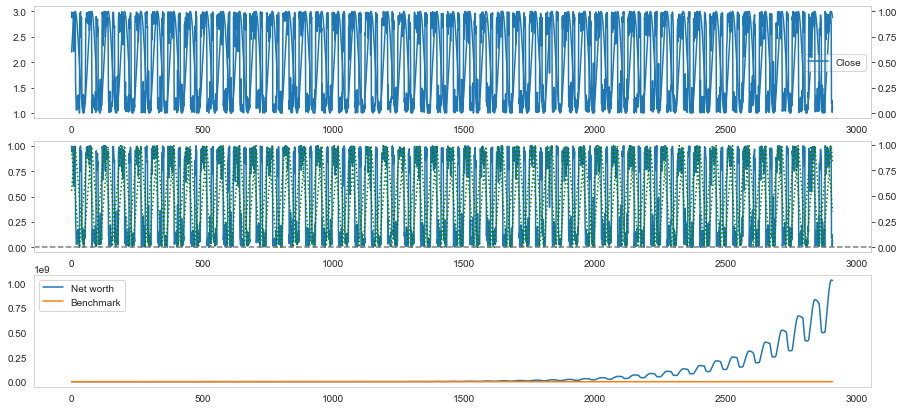

In [186]:
train_percent = 0.8
state_lookback = 1
num_dense_layers = 2
num_dense_layers_by_num_features = 2
alpha =  0.5
epsilon = 0.1
gamma = 0.1
episodes = 10
number_of_random_samples =  10
metric = "percent"
ticker = 'sinx'
df = module_methods.get_stock_data(ticker)
features = [
        {"feature": "Close_as_a_feature", "lookback": 0},
        {"feature": "diff_of_close", "lookback": 1},
    ]
df = module_methods.add_features(df, features, state_lookback, 0.8)
all_actions = {0: 'percentage_invested_in_equity'}
# test_df = df.iloc[int(0.8 * len(df)):, :]
train_df = df.iloc[:int(0.8 * len(df)), :]
best_model = module_methods.get_model(len(features) * state_lookback, len(all_actions), num_dense_layers,len(features) * state_lookback * num_dense_layers_by_num_features)
best_model.set_weights(multiprocessing_log[-1][1])
fig, score = module_methods.eval_q_learning(train_df, best_model, state_lookback,all_actions,number_of_random_samples, metric, features, save=True)
plt.show()

In [188]:
score

102960.37000658928

In [184]:
len(multiprocessing_log)

40

In [187]:
multiprocessing_log[-1]

(5281910030604502.0,
 [array([[ 0.23866835,  1.2162577 ,  0.06505632, -0.21124756],
         [ 0.73299575, -0.1973063 , -1.7198794 ,  1.2144173 ],
         [-0.01351892, -0.01056468,  0.00399137, -0.00709117]],
        dtype=float32),
  array([-0.5852769 , -0.5465784 ,  0.7718731 , -0.29024717], dtype=float32),
  array([[ 1.0127305 , -0.04861057,  0.85155696, -0.4416134 ],
         [ 0.5647556 , -0.7455595 ,  0.10816538,  0.47758064],
         [ 0.596323  ,  0.05796538,  0.6595511 ,  0.72614527],
         [-0.26737475, -0.13993078, -1.1672697 ,  0.63231313]],
        dtype=float32),
  array([ 0.12075193, -0.09465552, -0.15475655, -0.07996106], dtype=float32),
  array([[-0.10469808],
         [ 0.9313381 ],
         [-0.17316522],
         [ 0.27522162]], dtype=float32),
  array([-0.02188769], dtype=float32)])

In [175]:
multiprocessing_log[-1]

(5281910030604502.0,
 [array([[ 0.23866835,  1.2162577 ,  0.06505632, -0.21124756],
         [ 0.73299575, -0.1973063 , -1.7198794 ,  1.2144173 ],
         [-0.01351892, -0.01056468,  0.00399137, -0.00709117]],
        dtype=float32),
  array([-0.5852769 , -0.5465784 ,  0.7718731 , -0.29024717], dtype=float32),
  array([[ 1.0127305 , -0.04861057,  0.85155696, -0.4416134 ],
         [ 0.5647556 , -0.7455595 ,  0.10816538,  0.47758064],
         [ 0.596323  ,  0.05796538,  0.6595511 ,  0.72614527],
         [-0.26737475, -0.13993078, -1.1672697 ,  0.63231313]],
        dtype=float32),
  array([ 0.12075193, -0.09465552, -0.15475655, -0.07996106], dtype=float32),
  array([[-0.10469808],
         [ 0.9313381 ],
         [-0.17316522],
         [ 0.27522162]], dtype=float32),
  array([-0.02188769], dtype=float32)])

In [ ]:
module_methods.train_q_learning()

In [201]:
with open(f'returns_of_best_performing_model_so_far_sinx.pkl', 'wb') as file:
    pickle.dump(0,file)

In [202]:
with open(f'returns_of_best_performing_model_so_far_sinx.pkl', 'rb') as file:
    best_model_details = pickle.load(file)

In [194]:
print(int(best_model_details[0]))

3605492191811029504


In [203]:
best_model_details

2.8392436408736584e+16

In [205]:
for i in range(10):
    print(int(i))

0
1
2
3
4
5
6
7
8
9


In [206]:
os.getcwd()

'c:\\Users\\pratiksaxena\\Desktop\\Pratik\\AcsysAlgo_github\\RL\\SuprabhashKT\\RL\\V8-continuos_action_space_and_state_space'

In [ ]:
with open(f'c:\\Users\\pratiksaxena\\Desktop\\Pratik\\AcsysAlgo_github\\RL\\SuprabhashKT\\RL\\V8-continuos_action_space_and_state_space', 'rb') as file:
    best_model_details = pickle.load(file)

In [208]:
df = pd.DataFrame({"col1":[1,2,3,4,5],"col2":[7,8,9,10,12]})

In [210]:
df.columns[-1]

'col2'

In [215]:
feature = "technical_indicator_sqrt_TEMA_TEMA"
"_".join(feature.split("_")[3:])

'TEMA_TEMA'

In [217]:
lookbacks = [1,2,3,6]
lookbacks.extend([29])

In [221]:
lookbacks

[1, 2, 3, 6]

In [220]:
lookbacks = lookbacks[:-1]

In [279]:
with open(f'C:\\Users\\pratiksaxena\\Downloads\\neg_PE_ZS_lb.pkl', 'rb') as file:
    ze_score = pickle.load(file)

In [280]:
ze_score.set_index("Datetime",inplace=True)

In [287]:
with open(f'PE_ZS_neg_various_lb.pkl', 'wb') as file:
    pickle.dump(ze_score,file)

In [282]:
ze_score.index = pd.to_datetime(ze_score.index)


In [266]:
ze_score

,P/E,Close,PE_ZS_5,PE_ZS_10,PE_ZS_15,PE_ZS_30,PE_ZS_45,PE_ZS_60,PE_ZS_90,PE_ZS_100,PE_ZS_150,PE_ZS_252
Datetime,,,,,,,,,,,,
2000-01-03,25.91,1592.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,26.67,1638.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,25.97,1595.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,26.32,1617.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,26.25,1613.30,-0.085267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-30,20.65,16661.40,-1.517123,-2.046170,-2.093602,0.293315,0.736627,0.792037,1.058529,1.103719,1.347050,1.573044
2022-05-31,20.44,16584.55,-0.641373,-1.159665,-1.378672,0.442569,0.863529,0.953091,1.209308,1.216992,1.454084,1.636959
2022-06-01,20.45,16522.75,-0.387198,-1.012242,-1.335315,0.387542,0.823398,0.927397,1.190111,1.189325,1.441615,1.620758


In [233]:
with open(f'NIFc1_non_absolute_percentage_of_poc_vah_val_polv_and_ohlc_avg_across_various_lookbacks_for_all_days.pkl','rb') as file:
    vol_feats = pickle.load(file)/100

In [272]:
vol_feats.index

DatetimeIndex(['2007-01-16', '2007-01-17', '2007-01-18', '2007-01-19',
               '2007-01-22', '2007-01-23', '2007-01-24', '2007-01-25',
               '2007-01-29', '2007-01-31',
               ...
               '2022-05-06', '2022-05-09', '2022-05-10', '2022-05-11',
               '2022-05-12', '2022-05-13', '2022-05-16', '2022-05-17',
               '2022-05-18', '2022-05-19'],
              dtype='datetime64[ns]', length=3783, freq=None)

In [283]:
ze_score.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2022-05-23', '2022-05-24', '2022-05-25', '2022-05-26',
               '2022-05-27', '2022-05-30', '2022-05-31', '2022-06-01',
               '2022-06-02', '2022-06-03'],
              dtype='datetime64[ns]', name='Datetime', length=5578, freq=None)

In [286]:
pd.concat([vol_feats,ze_score],axis=1).dropna()

,10_day_lookback_poc,10_day_lookback_vah,10_day_lookback_val,10_day_lookback_polv,21_day_lookback_poc,21_day_lookback_vah,21_day_lookback_val,21_day_lookback_polv,63_day_lookback_poc,63_day_lookback_vah,...,PE_ZS_5,PE_ZS_10,PE_ZS_15,PE_ZS_30,PE_ZS_45,PE_ZS_60,PE_ZS_90,PE_ZS_100,PE_ZS_150,PE_ZS_252
2007-01-16,0.021760,0.013850,0.054116,0.014569,0.021760,0.013850,0.054116,0.014569,0.021760,0.013850,...,-0.654084,-0.982631,-1.216890,-1.254935,-1.521720,-1.706558,-1.655520,-1.535965,-1.305994,-1.474614
2007-01-17,0.020469,0.012548,0.055748,0.013268,0.020469,0.012548,0.055748,0.013268,0.020469,0.012548,...,-0.173972,-0.755452,-0.836839,-1.064347,-1.266895,-1.472484,-1.479818,-1.411407,-1.248304,-1.412796
2007-01-18,0.005017,-0.007479,0.045834,0.015013,0.005017,-0.007479,0.045834,0.015013,0.005017,-0.007479,...,-0.801784,-0.999500,-1.166020,-1.335767,-1.540221,-1.728303,-1.722130,-1.633214,-1.340709,-1.494997
2007-01-19,0.005526,-0.006964,0.046322,0.015517,0.005526,-0.006964,0.046322,0.015517,0.005526,-0.006964,...,1.539795,-0.188268,-0.175660,-0.711212,-0.777587,-1.029355,-1.142980,-1.141396,-1.120126,-1.291429
2007-01-22,0.004413,-0.011424,0.045256,-0.010590,0.004413,-0.011424,0.045256,-0.010590,0.004413,-0.011424,...,1.051499,-0.078730,-0.112072,-0.703807,-0.721100,-0.978384,-1.122897,-1.116693,-1.107648,-1.276015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-13,-0.031347,-0.064497,0.008218,-0.037763,-0.082513,-0.118855,-0.032714,-0.042135,-0.087069,-0.104703,...,1.050062,1.339627,1.643956,2.083890,2.277847,2.345290,2.064534,2.196820,1.972518,2.057897
2022-05-16,-0.033974,-0.058632,0.005692,-0.040407,-0.084789,-0.113973,-0.027691,-0.044187,-0.089838,-0.107517,...,0.989256,1.256316,1.515400,1.955271,2.283409,2.314315,2.070685,2.198818,1.998841,2.079554
2022-05-17,-0.018414,-0.021088,0.021695,-0.000588,-0.069637,-0.098413,-0.013336,-0.029601,-0.074615,-0.092046,...,-0.607917,0.563792,0.943876,1.490894,1.808807,1.797817,1.736609,1.849835,1.770249,1.914685
2022-05-18,0.000378,-0.009314,0.029452,0.010951,-0.051552,-0.071882,0.000877,-0.070812,-0.062223,-0.073188,...,-0.949549,0.468809,0.859163,1.406046,1.752814,1.746473,1.715935,1.819091,1.763427,1.908311


<AxesSubplot:xlabel='Datetime'>

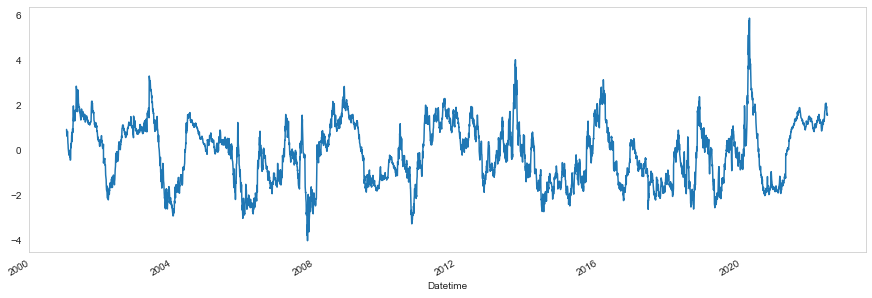

In [290]:
ze_score["PE_ZS_252"].plot()

In [296]:
np.random.uniform(0,1,50)

array([0.97433137, 0.16560478, 0.53590644, 0.55041851, 0.79899061,
       0.79921749, 0.72441476, 0.19975998, 0.14530761, 0.67977844,
       0.72701522, 0.94791178, 0.86944241, 0.94431538, 0.19056481,
       0.73026349, 0.43956858, 0.90383218, 0.99244754, 0.3591109 ,
       0.60025244, 0.35675993, 0.70599114, 0.46113836, 0.42468477,
       0.85557998, 0.06172049, 0.42502835, 0.57667495, 0.04846053,
       0.91501133, 0.95122669, 0.70042694, 0.98206682, 0.97414671,
       0.73071586, 0.60470694, 0.29383331, 0.26395941, 0.62052797,
       0.79172073, 0.28722362, 0.18767968, 0.98140458, 0.42523835,
       0.56566834, 0.18795372, 0.55947862, 0.00268031, 0.42486879])

In [298]:

with open(f'C:\\Users\\pratiksaxena\\Downloads\\increasing_pivots_NIFc1_piv_type.pkl','rb') as file:
    incr_pivots = pickle.load(file)

In [303]:
incr_pivots.fillna(0)

,incr_pivs,pivot_type
Datetime,,
2007-01-02,0.0,0
2007-01-03,0.0,0
2007-01-04,0.0,0
2007-01-05,0.0,0
2007-01-08,0.0,0
...,...,...
2022-06-03,0.0,0
2022-06-06,4.0,-1
2022-06-07,0.0,1


In [304]:
with open(f'increasing_pivots_NIFc1_piv_type.pkl', 'wb') as file:
    pickle.dump(incr_pivots.fillna(0),file)

In [306]:
incr_pivots.index

DatetimeIndex(['2007-01-02', '2007-01-03', '2007-01-04', '2007-01-05',
               '2007-01-08', '2007-01-09', '2007-01-10', '2007-01-11',
               '2007-01-12', '2007-01-15',
               ...
               '2022-05-27', '2022-05-30', '2022-05-31', '2022-06-01',
               '2022-06-02', '2022-06-03', '2022-06-06', '2022-06-07',
               '2022-06-08', '2022-06-09'],
              dtype='datetime64[ns]', name='Datetime', length=3808, freq=None)

In [311]:
state_lookback=1
for i in range(state_lookback):
    print(i)

0


In [313]:
df["shift"] = df["col2"].shift(1)

In [314]:
df

,col1,col2,shift
0,1,7,NaN
1,2,8,7.0
2,3,9,8.0
3,4,10,9.0
4,5,12,10.0


In [315]:
import investpy

In [320]:
symbol = "RELI"
country = "India"

find = investpy.search.search_quotes(text=symbol, products=["stocks", "etfs", "indices", "currencies"])
for f in find:
    # print( f )
    if f.symbol.lower() == symbol.lower() and f.country.lower() == country.lower():
        break
if f.symbol.lower() != symbol.lower():
    ret =  None
ret = f.retrieve_historical_data(from_date="01/01/2022", to_date="01/06/2022")
if ret is None:
    try:

        ret = investpy.get_stock_historical_data(stock=symbol,
                                                    country=country,
                                                    from_date="01/01/2022",
                                                    to_date="01/06/2022")

    except:
        ret = None

In [321]:
ret

,Open,High,Low,Close,Volume,Change Pct
Date,,,,,,
2022-01-03,2365.00,2407.95,2363.55,2403.85,2502073,1.51
2022-01-04,2415.90,2461.00,2404.00,2458.10,5006225,2.26
2022-01-05,2462.00,2477.00,2432.95,2469.60,5373618,0.47
2022-01-06,2451.20,2454.00,2409.00,2416.50,6667483,-2.15
2022-01-07,2430.95,2458.05,2411.55,2436.00,6051239,0.81
...,...,...,...,...,...,...
2022-05-26,2624.40,2634.90,2548.00,2587.10,8252551,-0.95
2022-05-27,2593.05,2605.15,2540.10,2575.10,7624888,-0.46
2022-05-30,2615.00,2674.00,2594.20,2664.80,6393341,3.48


In [326]:
max(ret.index[1],ret.index[3])

Timestamp('2022-01-06 00:00:00')

In [329]:
lol = [1,2,3,4,5]

In [330]:
lol.index(1)

0

In [331]:
with open("C:\\Users\\pratiksaxena\\Downloads\\BJFS_OptPeriods_2_Selected_Strategies_ss_correct.pkl","rb") as file:
    ss_list = pickle.load(file)

In [333]:
len(ss_list)

44

In [336]:
get_stock_data("HST.OQ")

,Close,High,Low,Open,Volume
Datetime,,,,,
1980-03-17,3.314537,3.336344,3.270925,0.00,110634.0
1980-03-18,3.530000,3.530000,3.390000,3.53,252613.0
1980-03-19,3.590000,3.640000,3.500000,3.59,102711.0
1980-03-20,3.530000,3.620000,3.530000,3.53,230405.0
1980-03-21,3.500000,3.570000,3.480000,3.50,92162.0
...,...,...,...,...,...
2022-06-07,21.160000,21.180000,20.740000,20.90,2370550.0
2022-06-08,20.940000,21.205000,20.750000,21.05,2081975.0
2022-06-09,19.910000,20.940000,19.900000,20.94,1998729.0


In [11]:
directory_path = os.getcwd()
best_returns = 0
ticker = "NIFc1"
for i in range(4):
    with open(f'{directory_path}\\selected_models\\returns_model_{ticker}_{int(i)}.pkl', 'rb') as file:
        best_returns_for_current_process = pickle.load(file)
    if best_returns_for_current_process>best_returns:
        best_model_path = f'{directory_path}\\selected_models\\model_{ticker}_{int(i)}'
        best_returns = best_returns_for_current_process

In [12]:
best_returns

2.7475746906107315

In [355]:
best_model_path

'c:\\Users\\pratiksaxena\\Desktop\\Pratik\\AcsysAlgo_github\\RL\\SuprabhashKT\\RL\\V8-continuos_action_space_and_state_space\\selected_models\\model_NIFc1_2'

In [7]:
import pandas as pd
df = pd.DataFrame({"col1":[1,2,3,4,5]*30,"col2":[6,7,8,9,10]*30})

In [10]:
# roll = df["col2"].rolling(3)
from hurst import *
df[f'H{100}'] = df["col2"].rolling(100).apply(lambda x: compute_Hc(x.to_numpy(), kind='price', simplified=False)[0])
# df[f'z_score_{"col2"}_{3}'] = (df["col2"] - roll.mean()) / roll.std()

In [13]:
df[f'sum2'] = df["col2"].rolling(2).apply(lambda x: (x+2)[0])

KeyError: 0

In [19]:
m_a_s = df.iloc[0:100]["col2"] - df.iloc[0:100]["col2"].mean()

In [22]:
cum_a_s = m_a_s.cumsum()

In [24]:
min(cum_a_s)

-3.0

In [27]:
m_a_s.std(ddof=1)

1.4213381090374029

In [2]:
import pickle
with open("C:\\Users\\pratiksaxena\\Desktop\\Pratik\\AcsysAlgo_github\\RL\\SuprabhashKT\\Utils\\.NSEI_Constituents.pkl","rb") as file:
    constituents_df = pickle.load(file)


In [8]:
constituents_df.iloc[-1]["Tickers"][37]

'RELI.NS'

In [16]:
True and True

True

In [22]:
buy_mask = (df["col2"] < 2) & (df["col1"] > 2) & (
                    df["col1"] < df[f"col2"])

In [26]:
import numpy as np
df['signal'] = np.nan
df.loc[~buy_mask, 'signal'] = 1

In [1]:
df.rolling(2)

NameError: name 'df' is not defined

In [28]:
[x for x in range(100,3100,100)]

[100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400,
 2500,
 2600,
 2700,
 2800,
 2900,
 3000]

In [30]:
df = get_stock_data("NIFc1")

NameError: name 'get_stock_data' is not defined